# Large Scale Face recognition

What if your dataset contains thousands of identities, with thousands of pictures for each of them? It will be impossible to compare their embeddings one-by-one to find the closest match. This notebook will show you how to use `nmslib`, a similarity search library based on approximate nearest neighbors (ANN).

source: https://github.com/nmslib/nmslib 

In [68]:
import cv2
import matplotlib.pyplot as plt
import keras_vggface as kv
import modules.utils as utils
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import nmslib

In [69]:
# Declare a FacePreprocess instance.
from modules.FacePreprocess import FacePreprocess
ssd_model = r'./models/ssd/deploy.prototxt.txt'
ssd_weights = r'./models/ssd/res10_300x300_ssd_iter_140000.caffemodel'
processor = FacePreprocess(ssd_model, ssd_weights)

In [70]:
# Use the facial embedding model you want to use
model = kv.VGGFace(
    model='resnet50', 
    include_top=False, 
    input_shape=(224, 224, 3), 
    pooling='avg'
)
input_size = (224, 224)

## Compute Embeddings

Since we want to build a tree using the facial embeddings, let's compute embeddings of all the images in our dataset. 

In [71]:
id_list = pd.DataFrame(columns=['name', 'file'])
embeddings = []
for id in os.listdir('./dataset/train/'):
    folder = './dataset/train/{}/'.format(id)
    for file in os.listdir(folder):
        try:
            filepath = os.path.join(folder, file)
            processed_img = processor.preproc(cv2.imread(filepath))[0][0]
            embedding = model.predict(utils.resize(processed_img, input_size), verbose=False)[0,:]

            id_list.loc[len(id_list.index)] = [id, filepath]
            embeddings.append(embedding)
        except:
            print('Failed to process/predict {}'.format(filepath))
embeddings = np.array(embeddings, dtype='f')
print('='*10 + '\n{} images processed.'.format(len(embeddings)))

25 images processed.


## Initialize nmslib 

For more details about the method and space parameter, please check the references below.

Reference:
- [nmslib sample notebooks](https://github.com/nmslib/nmslib/blob/master/python_bindings/notebooks/search_vector_dense_optim.ipynb)
- [nmslib methods](https://github.com/nmslib/nmslib/blob/master/manual/methods.md)
- [nmslib spaces](https://github.com/nmslib/nmslib/blob/master/manual/spaces.md)

#### 1. Using Euclidean distance

In [72]:
# Set index parameters
index_time_params = {'M': 15, 'indexThreadQty': 4, 'efConstruction': 100, 'post' : 0}

# Initialize
index_l2 = nmslib.init(
    method = 'hnsw', # hierarchical navigable small world graph
    space = 'l2', # euclidean
    data_type = nmslib.DataType.DENSE_VECTOR
) 

# build the index
index_l2.addDataPointBatch(embeddings)
index_l2.createIndex(index_time_params)

#### 2. Using cosine similarity

In [73]:
# Initialize
index_cos = nmslib.init(
    method = 'hnsw', # hierarchical navigable small world graph
    space = 'cosinesimil', # cosine
    data_type = nmslib.DataType.DENSE_VECTOR
) 

# build the index
index_cos.addDataPointBatch(embeddings)
index_cos.createIndex(index_time_params)

## Predict an image

Now that our library has been built, let's test if it can predict the person in our test image. For this example we will use a picture of Joy

1/1 [==============================] - 0s 89ms/step


Text(0.5, 1.0, 'target image')

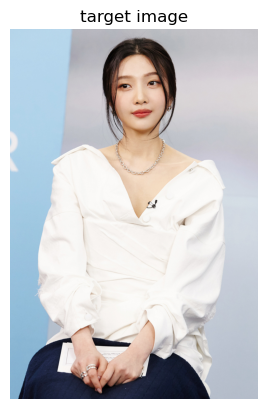

In [74]:
# prepare our target image
img = cv2.imread('./dataset/test/test_1.jpg')
preprocessed = processor.preproc(img)[0][0]
target_representation = model.predict(utils.resize(preprocessed, input_size))[0,:]
target_representation = np.array(target_representation, dtype='f')
target_representation = np.expand_dims(target_representation, axis=0)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("target image")

#### 1. Using Euclidean distance

In [75]:
# Query the library
neighbors, distances = index_l2.knnQueryBatch(target_representation, k=3, num_threads=4)[0]

`k` is the number of the nearest neighbors it will return. Let's unpack our results.

In [76]:
results = [[
    id_list['name'][neighbors[i]], id_list['file'][neighbors[i]], distances[i],
] for i in range(len(neighbors))]
results = pd.DataFrame(results, columns = ['name', 'file', 'euclidean distance'])
results

,name,file,euclidean distance
0,joy,./dataset/train/joy/img_4.jpg,3361.965576
1,joy,./dataset/train/joy/img_2.jpg,4142.544434
2,joy,./dataset/train/joy/img_5.jpg,4406.583008


#### 2. Using cosine similarity

In [77]:
# Query the library
neighbors, distances = index_cos.knnQueryBatch(target_representation, k=3, num_threads=4)[0]
results = [[
    id_list['name'][neighbors[i]], id_list['file'][neighbors[i]], distances[i],
] for i in range(len(neighbors))]
results = pd.DataFrame(results, columns = ['name', 'file', 'cosine similarity'])
results

,name,file,cosine similarity
0,joy,./dataset/train/joy/img_4.jpg,0.173276
1,joy,./dataset/train/joy/img_5.jpg,0.179900
2,joy,./dataset/train/joy/img_2.jpg,0.190925


As we can see, the 3 closest neighbours to our target image is also Joy, so our library has predicted correctly! 

## Saving the Model

We can also save our model, so we don't have to compute embeddings and rebuild the library everytime we want to use it. 

In [78]:
output_path = './output/large_scale_face_recognition/'

In [79]:
# you should create the folder first before running this code
index_l2.saveIndex(output_path + 'index_l2.bin', save_data=False)
index_cos.saveIndex(output_path + 'index_cos.bin', save_data=False)

Since nmslib doesn't save a mapping between the index number and name, let's export that too. Both `euclidean distance` and `cosine similarity` uses the same dataset, so we only need to save one copy.

In [80]:
id_list.to_csv(output_path + '/IDlist.csv', index=False)

## Load model

In [81]:
# load id_list
new_id_list = pd.read_csv(output_path + '/IDlist.csv')

# Euclidean distance
newindex_l2 = nmslib.init(method='hnsw', space='l2', data_type=nmslib.DataType.DENSE_VECTOR)
newindex_l2.loadIndex(output_path + 'index_l2.bin')

# Cosine similarity
newindex_cos = nmslib.init(method='hnsw', space='cosinesimil', data_type=nmslib.DataType.DENSE_VECTOR)
newindex_cos.loadIndex(output_path + 'index_cos.bin')

\>\> Let's try to predict using the loaded model

In [82]:
# Euclidean distance
neighbors, distances = newindex_l2.knnQueryBatch(target_representation, k=3, num_threads=4)[0]
results = [[
    new_id_list['name'][neighbors[i]], new_id_list['file'][neighbors[i]], distances[i],
] for i in range(len(neighbors))]
results = pd.DataFrame(results, columns = ['name', 'file', 'euclidean distance'])
results

,name,file,euclidean distance
0,joy,./dataset/train/joy/img_4.jpg,3361.965576
1,joy,./dataset/train/joy/img_2.jpg,4142.544434
2,joy,./dataset/train/joy/img_5.jpg,4406.583008


In [83]:
# Cosine similarity
neighbors, distances = newindex_cos.knnQueryBatch(target_representation, k=3, num_threads=4)[0]
results = [[
    new_id_list['name'][neighbors[i]], new_id_list['file'][neighbors[i]], distances[i],
] for i in range(len(neighbors))]
results = pd.DataFrame(results, columns = ['name', 'file', 'cosine similarity'])
results

,name,file,cosine similarity
0,joy,./dataset/train/joy/img_4.jpg,0.173276
1,joy,./dataset/train/joy/img_5.jpg,0.179900
2,joy,./dataset/train/joy/img_2.jpg,0.190925


## Conclusion

In this notebook I've showed how to build, save, and load index using `nmslib`. Using a similarity search library like this simplifies the process of face recognition, we don't have to compute embeddings and compare distances every single time (which can be costly, think of datasets with hundreds or thousands of subjects). I hope you find this notebook useful!